In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

# load data

In [2]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

# Time series split

In [3]:
x_train.columns

Index(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'Contract_1',
       'InternetService_1', 'MultipleLines_1'],
      dtype='object')

In [4]:
tscv = TimeSeriesSplit(n_splits=10)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=10)

# Training XgBoost model

tune num_estimators first

## tuning num_estimators

In [7]:
num_estimators_list = [15, 20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 400]

tscv_loss_dict = {}
for ix, ne in enumerate(num_estimators_list):
    print(f"num_estimators {ne}")

    tscv_loss_list = []

    for train_index, cv_index in tscv.split(x_train):

        # get data for cv ready
        x_train_req = x_train.iloc[train_index]
        x_cv_req = x_train.iloc[cv_index]

        y_train_req = y_train.iloc[train_index]
        y_cv_req = y_train.iloc[cv_index]

        # print(f"len_train {len(train_index)}, len_cv {len(cv_index)}")
        clf = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=ne,
            eval_metric="rmse",
            booster="gbtree",
        )
        clf.fit(x_train_req, y_train_req)

        # get log los train
        y_pred_train_mse = clf.predict(x_train_req)
        mse_train = mean_squared_error(y_train_req, y_pred_train_mse)

        # get log los cv set
        y_pred_val_mse = clf.predict(x_cv_req)
        mse_cv = mean_squared_error(y_cv_req, y_pred_val_mse)

        tscv_loss_list.append({"mse_train": mse_train, "mse_cv": mse_cv})

    tscv_loss_dict[ix] = tscv_loss_list

num_estimators 15
num_estimators 20
num_estimators 30
num_estimators 40
num_estimators 50
num_estimators 60
num_estimators 70
num_estimators 100
num_estimators 150
num_estimators 200
num_estimators 250
num_estimators 300
num_estimators 400


In [8]:
df_tscv = pd.DataFrame(tscv_loss_dict.items()).rename(
    columns={0: "iteration", 1: "losses"}
)

df_tscv["mse_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["mse_train"] for i in x])
)
df_tscv["mse_cv"] = df_tscv["losses"].apply(lambda x: np.mean([i["mse_cv"] for i in x]))


df_tscv["num_estimators"] = num_estimators_list
df_tscv = df_tscv.drop(columns=["losses"])
df_tscv

,iteration,mse_train,mse_cv,num_estimators
0,0,1.557396,5.779316,15
1,1,1.133663,5.396506,20
2,2,0.828780,5.153103,30
3,3,0.655749,5.041291,40
4,4,0.543240,4.995203,50
5,5,0.459428,4.963162,60
6,6,0.394289,4.945192,70
7,7,0.267401,4.929558,100
8,8,0.159773,4.921832,150
9,9,0.103521,4.929719,200


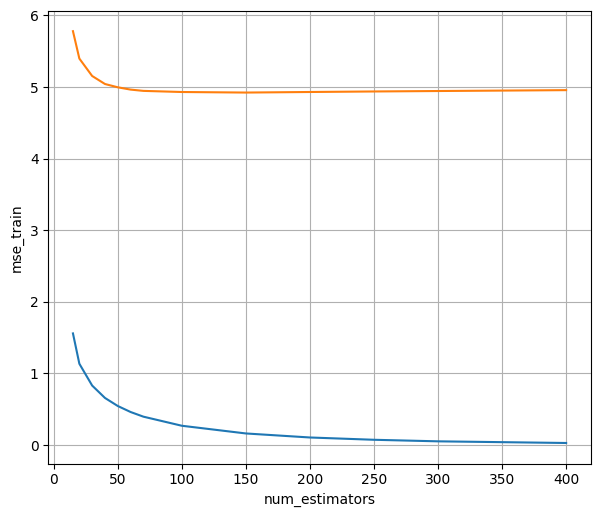

In [9]:
plt.figure(figsize=[7, 6], dpi=100)
sns.lineplot(y="mse_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="mse_cv", x="num_estimators", data=df_tscv)
plt.grid()

Using `n_estimators = 250` as best param

## re-train with best num_estimators

In [10]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

In [11]:
clf = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=250,
    eval_metric="rmse",
    booster="gbtree",
)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

# Fine tuning Random Forest Model

In [13]:
%%time

# using best n_estimators got from training


clf = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=250,
    eval_metric="logloss",
    booster="gbtree",
)


param_grid = {
    "colsample_bytree": [0.2, 0.5, 0.9, 1],
    "learning_rate": [0.01, 0.1, 0.25, 0.3],
    "max_depth": [2, 3, 4],
    "reg_alpha": [1e-3, 1e-2, 0.1, 1],
    "reg_lambda": [1e-3, 1e-2, 0.1, 1]
    # "subsample": [0.2, 0.5, 0.8, 0.9, 1],
}


grid_search_clf = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=None,
    refit=True,
    scoring="neg_mean_squared_error",
)
grid_search_clf.fit(x_train, y_train)

CPU times: user 3h 20min 7s, sys: 3min 6s, total: 3h 23min 14s
Wall time: 17min 23s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='logloss', gamma=None,
                                    gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=250,
                                    n_jobs=None, num_parallel_tree=None,
        

In [15]:
grid_search_clf.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_alpha': 1,
 'reg_lambda': 0.1}

In [16]:
y_pred_train = grid_search_clf.predict(x_train)
y_pred_test = grid_search_clf.predict(x_test)

## Check mse

In [17]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test = mean_squared_error(y_test, y_pred_test)

print(f"mse train {mean_squared_error_train}")
print(f"mse test {mean_squared_error_test}")

mse train 1.155758624430505
mse test 5.208760787799311


# Save model

In [18]:
os.makedirs("../data/models/reg/xgboost/", exist_ok=True)

In [19]:
joblib.dump(grid_search_clf.best_estimator_, "../data/models/reg/xgboost/xgb_model.pkl")

['../data/models/reg/xgboost/xgb_model.pkl']